Reference: [Makhzani, A.; Shlens, J.; Jaitly, N.; Goodfellow, I. Adversarial Autoencoders. 2016](https://arxiv.org/abs/1511.05644)

논문이 주장하는 바는 abstract에서 이 한 문장으로 서술되는 것 같다.  
  
**Matching the aggregated posterior to the prior ensures that generating from any
part of prior space results in meaningful samples.**  
  
즉, condition들이 더해져서 만들어진 posterior를 원래의 prior와 맞추어가면서, prior latent space의 모든 영역에서부터 생성할 수 있다.

Adversarial autoencoder는 autoencoder에 GAN을 추가시킨 것이다. 크게 두 가지를 통하여 학습이 되는데 하나는 autoencoder의 reconstruction error이고, 두 번째는 GAN의 기준이다. 후자는 autoencoder latent vector에 임의의 조건이 더해져서 만들어진 posterior distribution의 원래 형태인 prior distribution을 맞추는 것이다. 이를 통해 encoder는 data를 prior distribution으로 바꾸는 법을 배우고, decoder는 input으로 들어온 prior를 data로 다시 바꿔주는 deep generative model을 학습한다. 아래의 설명은 [이곳](https://ratsgo.github.io/generative%20model/2018/01/28/VAEs/)을 조금 참고하였다.
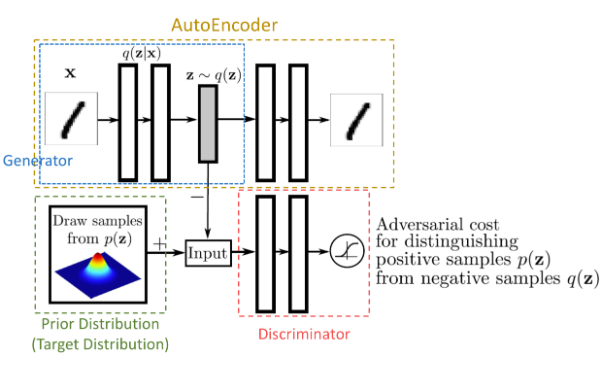
위의 그림이 AAE의 구조를 보여주는데, 위쪽 부분은 AE, 아래쪽은 AE로부터 나온 vector을 이용한 GAN이다. VAE의 loss function은 reconstruction 부분과 regularizaiton 부분이 있는데 VAE에서는 regularization term을 계산할 때 prior distribution $p(z)$를 특정 model로 단정시킨다. 이러한 VAE의 단점 중 하나는 prior distribution과 posterior distribution이 정규분포가 되어야 모델이 잘 돌아간다는 것이다. 그렇기 때문에 복잡한 모델에 대해서는 쉽게 학습이 되지 않는다. 하지만 GAN의 경우 모델의 확률분포에 상관없이 데이터의 실제 분포와 모델이 만들어내는 분포의 차이를 줄이도록 학습되기 때문에 분포의 종류는 전혀 상관이 없다. 그런 의미에서 AAE에서의 autoencoder의 encoder가 GAN의 generator역할을 하여 데이터 $x$로부터 latent vector $z$와 $z$가 reparamitize된 $q(z)$가 만들어진다. Autoencoder의 decoder는 이 $q(z)$로부터 다시 $x$를 복원한다. GAN의 discriminator는 실제 데이터의 분포 $p(z)$와 reparamitize된 $q(z)$를 구분하면서 학습되고, autoencoder는 데이터 $x$를 잘 복원할 수 있도록 학습된다.

Reconstruction 부분과 regularization 부분이 있다. Reconstruction은 일반적인 autoencoder와 같이 encoder와 decoder로 하여금 데이터 $x$의 복원률을 높이도록 학습시키는 과정이다. Regularization 부분은 adversarial network에 의해 진행된다. 먼저 discriminative network가 데이터로부터 만들어낸 true sample과 autoencoder로부터 생성된 generated sample의 차이를 구분하도록 학습시키고, 이후 generator를 discriminative network가 구분을 잘 하지 못하게 sample을 만들어내도록 학습시킨다. 

*참고로 encoder의 종류를 선택하여 사용할 수 있는데, 이에 따라 다른 모델이 만들어진다.*
1. Deterministic  
    $q(z|x)$가 $z$의 determisitic function이라고 가정하면, 일반적인 autoencoder의 encoder 부분과 동일하게 보면 된다. 데이터 $x$로부터 latent vector $z$를 만들고 이를 sampling시켜 $q(z)$를 만드는 것이다.
2. Gaussian posterior  
    $q(z|x)$가 gaussian distribution이라고 가정하면, encoder를 통하여 gaussian distribution의 mean과 variance를 예측하는 것이다. Reparamatization trick이라는 방법을 써서 $z = \mu (x) + \sigma (x) \times \epsilon , \epsilon \sim N(0,1)$ sampled latent vector $z$를 만든다.
3. Universal approximator posterior  
    Encoder $f(x, \eta)$는 특정 함수로써 gaussian distribution과 같은 정해진 distribution에 데이터 $x$와 random noise $\eta$ 두 가지를 변수로 받는다. **(뒷부분은 이해가 잘 되지 않음...)**

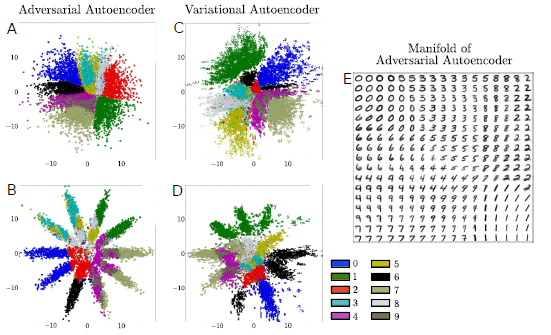
위 사진은 MNIST 데이터셋에 대한 AAE와 VAE의 비교이다. A와 B가 C와 D에 비해 빈 공간이 적고 clustering도 훨씬 잘 되어있는 것을 볼 수 있다. VAE와 AAE의 큰 차이점 중 하나는 위에 말한 것처럼 VAE는 gaussian distribution과 같은 목표 함수에 대한 정확한 형태가 필요한 반면, AAE는 그냥 latent vector를 추출하기만 하면 목표 함수 $p(z)$에 비슷한 $q(z)$를 만들어낼 수 있다.

AAE의 학습과정
* step 1: update AE - update $\phi, \theta$ according to reconstruction error
$$L_i (\phi, \theta, x_i) = - E_{q_\theta(z|x_i)}[log(p_\theta (x_i|z))]$$
* step 2: update Discriminator - update $\lambda$ according to loss for discriminator
$$-V_i(\phi, \lambda, x_i, z_i) = -logd_\lambda (z_i) - log(1 - d_\lambda (q_\theta (x_i)))$$
* stpe 3: update Generator - update $\phi$ according to loss for discriminator
$$-V_i(\phi, \lambda, x_i, z_i) = -log(d_\lambda (q_\phi (x_i)))$$

In [ ]:
#AAE's pytorch code
import torch
import torch.nn as nn

encoder = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, latent_dim))

decoder = nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, input_dim),
                        nn.Sigmoid())

discriminator = nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                              nn.ReLU(),
                              nn.Linear(hidden_dim, 1),
                              nn.Sigmoid())

#step 1 - reconstruction loss
latent_sample = encoder(X)
input_sample = decoder(latent_sample)
reconstruction_loss = nn.binary_cross_entropy(input_sample, X)

#step 2 - discriminator loss
latent_real = Variable(torch.randn(batch_size, latent_dim))
latent_fake = encoder(X)
discriminator_real = discriminator(latent_real)
discriminator_fake = discriminator(latent_fake)
discriminator_loss = -torch.mean(torch.log(discriminator_real) + torch.log(1 - discriminator_fake))

#step 3 - generator loss
latent_fake = encoder(X)
discriminator_fake = discriminator(latent_fake)
generator_loss = -torch.mean(torch.log(discriminator_fake))

The result of the training is that the encoder learns to convert the data distribution to the prior distribution, while the decoder learns a deep generative model that maps the imposed prior to the data distribution.